In [49]:
# SLM Auto Importer v4 debugv1
# slimmed down from v3 - 
import openpyxl 
import string
import time
import pandas as pd
from pandas import ExcelWriter
import numpy as np
from openpyxl import load_workbook
from openpyxl import Workbook
from openpyxl import cell
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Table,Paragraph
from openpyxl.utils import get_column_letter
import xlsxwriter
import matplotlib.pyplot as plt
from os import listdir, walk
from os.path import isfile, join
import tkinter as tk
from tkinter import *
import win32com
# from win32com import client
import shutil

# import win32com.client


In [5]:
def format_SLMdata(srs_data):
    srs_thirdoct = srs_data.iloc[7] # hardcoded to SLM export data format
    srs_thirdoct = srs_thirdoct[14:30] # select only the frequency bands of interest
    return srs_thirdoct

def calc_AIIC_val(ATL_val):
    pos_diffs = list()
    diff_negative = 0
    diff_positive = 0
    AIIC_start = 0
    New_curve = list()
    new_sum = 0
    IIC_curve = [2,2,2,2,2,2,2,1,-110,-1,-2,-3,-6,-9,-12,-15,-18]
    while (diff_negative < 8 and new_sum < 32):
        # print('starting loop')
        print('AIIC fit test value: ', AIIC_start)
        for vals in IIC_curve:
            New_curve.append(vals+AIIC_start)
        IIC_curve = New_curve - ATL_val
        # print('ASTC curve: ',ASTC_curve)

        diff_negative =  np.max(IIC_curve - ATL_val)
        print('Max, single diff: ', diff_negative)
        for val in IIC_curve:
            if val > 0:
                pos_diffs.append(np.round(val))
            else:
                pos_diffs.append(0)
        # print(pos_diffs)
        new_sum = np.sum(pos_diffs)
        print('Sum Positive diffs: ', new_sum)
        # AIIC_curve_fitplotter(IIC_curve,New_curve)
        if new_sum > 32 or diff_negative > 8:
            print('Curve too high! AIIC fit: ', AIIC_start-1)
            return AIIC_start-1
            # print('Result for test: ', find_test) 
            # print('-=-=-=-=-=-=-=-=-')
            # break 
        pos_diffs = []
        New_curve = []
        AIIC_start = AIIC_start + 1
        if AIIC_start >80: break


In [38]:
def calc_ATL_val(srs_overalloct,rec_overalloct,bkgrnd_overalloct,rt_thirty,parition_area,recieve_roomvol):
    ASTC_vollimit = 883
    if recieve_roomvol > ASTC_vollimit:
        print('Using NIC calc, room volume too large')
    # constant = np.int32(20.047*np.sqrt(273.15+20))
    # intermed = 30/rt_thirty ## why did i do this? not right....sabines calc is off
    # thisval = np.int32(recieve_roomvol*intermed)
    # sabines =thisval/constant
    sabines = 0.049*(recieve_roomvol/rt_thirty)  # this produces accurate sabines values
    recieve_corr = list()
    recieve_vsBkgrnd = rec_overalloct - bkgrnd_overalloct
    for i, val in enumerate(recieve_vsBkgrnd):
        if val < 5:
            recieve_corr.append(rec_overalloct.iloc[i]-2)
        elif val < 10:
            recieve_corr.append(np.log10(10**(rec_overalloct.iloc[i]/10)-10**(bkgrnd_overalloct.iloc[i]/10)))
        else:
            recieve_corr.append(rec_overalloct.iloc[i])
    recieve_corr = np.round(recieve_corr,1)
    ATL_val = srs_overalloct - recieve_corr+10*(np.log10(parition_area/sabines))
    return ATL_val

In [34]:
testplan_path ='//DLA-04/Shared/KAILUA PROJECTS/2024/24-004 Kaulu by Gentry ASTC - AIIC testing/Documents/TestPlan_Kaulu_ASTM_testingv1.xlsx'
Aslmdatapath = '//DLA-04/Shared/KAILUA PROJECTS/2024/24-004 Kaulu by Gentry ASTC - AIIC testing/Test Data/RawData/A_Meter/'
Eslmdatapath = '//DLA-04/Shared/KAILUA PROJECTS/2024/24-004 Kaulu by Gentry ASTC - AIIC testing/Test Data/RawData/E_Meter/'
testplanfile = pd.read_excel(testplan_path)
testnums = testplanfile['Test Label'] ## Determines the labels and number of excel files copied
curr_test = testplanfile.iloc[0]
print(curr_test)    

Area                                              NaN
Area Label                                        NaN
Test Label                                      1.1.1
Source Room                      2nd Floor Great Room
Receiving Room           1st Floor Great Room/Kitchen
Partition Type                          Floor-ceiling
Design STC                                         47
Test Date                         2024-04-04 00:00:00
Report Date                       2024-04-15 00:00:00
Source                                           A029
Recieve                                          E264
BNL                                              E263
RT                                               E140
Position1                                        E265
Position2                                        E266
Position3                                        E267
Position4                                        E268
Carpet                                           E269
SourceTap                   

In [35]:
# need to modify for testing without GUI
def RAW_SLM_datapull(find_datafile, datatype):
    # pass datatype as '-831_Data.' or '-RT_Data.' to pull the correct data
    raw_testpaths = {
        'A': Aslmdatapath,
        'E': Eslmdatapath,
        # 'A': self.slm_data_a_path
    }
    datafiles = {}
    for key, path in raw_testpaths.items():
        datafiles[key] = [f for f in listdir(path) if isfile(join(path, f))]

    if find_datafile[0] in datafiles:
        print('data found')
        print(datafiles[find_datafile[0]])
        datafile_num = datatype + find_datafile[1:] + '.xlsx'
        print(datafile_num)
        slm_found = [x for x in datafiles[find_datafile[0]] if datafile_num in x]
        slm_found[0] = raw_testpaths[find_datafile[0]] + slm_found[0]  # If this line errors, the test file is mislabeled or doesn't exist 

    print(slm_found[0])
    if datatype == '-831_Data.':
        srs_data = pd.read_excel(slm_found[0], sheet_name='OBA')
    elif datatype == '-RT_Data.':
        srs_data = pd.read_excel(slm_found[0], sheet_name='Summary')  # data must be in Summary tab for RT meas.
    # srs_data = pd.read_excel(slm_found[0], sheet_name='OBA')  # data must be in OBA tab
    # potentially need a write to excel here...similar to previous function
    # just for 
    return srs_data

In [36]:
# this just needs to validate that the proper test data is pulled from the test dataframe such that ATL and 
find_test = '1.1.1'
# find_test = single_test_text_input_value
mask = testplanfile.applymap(lambda x: find_test in x if isinstance(x,str) else False).to_numpy()
indices = np.argwhere(mask) 
# print(indices)

index = indices[0,0]
# print(index)
# status_text_box.insert(tk.END,testplanfile.iloc[index])
foundtest = testplanfile.iloc[index]
# print the found test in the status box
# status_text_box.insert(tk.END, foundtest) # must come before mainloop
# print(foundtest)
report_string = '_'+find_test+'_' 
# status_text_box.insert(tk.END, f"Report string: '{report_string}'")
# status_text_box.insert(tk.END, f"Report list: '{reports}'")
# curr_report_file = [x for x in reports if report_string in x]
# print('Current report file: ',curr_report_file)
# print(curr_report_file[0]) #print the name of the report file being used
print('Current Test:', foundtest)
# curr_test = testplanfile.iloc[index]

# single_AIIC_test_data = pull_testplan_data(curr_test)

Current Test: Area                                              NaN
Area Label                                        NaN
Test Label                                      1.1.1
Source Room                      2nd Floor Great Room
Receiving Room           1st Floor Great Room/Kitchen
Partition Type                          Floor-ceiling
Design STC                                         47
Test Date                         2024-04-04 00:00:00
Report Date                       2024-04-15 00:00:00
Source                                           A029
Recieve                                          E264
BNL                                              E263
RT                                               E140
Position1                                        E265
Position2                                        E266
Position3                                        E267
Position4                                        E268
Carpet                                           E269
SourceTap     

C:\Users\jPfitsch\AppData\Local\Temp\ipykernel_44100\4280048954.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = testplanfile.applymap(lambda x: find_test in x if isinstance(x,str) else False).to_numpy()


In [32]:
room_properties = pd.DataFrame(
{
    "Source Room Name": curr_test['Source Room'],
    "Recieve Room Name": curr_test['Receiving Room'],
    "Testdate": curr_test['Test Date'],
    "ReportDate": curr_test['Report Date'],
    "Project Name": curr_test['Project Name'],
    "Test number": curr_test['Test Label'],
    "Source Vol" : curr_test['source room vol'],
    "Recieve Vol": curr_test['receive room vol'],
    "Partition area": curr_test['partition area'],
    "Partition dim.": curr_test['partition dim'],
    "Source room Finish" : curr_test['source room finish'],
    "Recieve room Finish": curr_test['receive room finish'],
    "Srs Floor Descrip.": curr_test['srs_floor'],
    "Srs Ceiling Descrip.": curr_test['srs_ceiling'],
    "Srs Walls Descrip.": curr_test['srs_Walls'],
    "Rec Floor Descrip.": curr_test['rec_floor'],
    "Rec Ceiling Descrip.": curr_test['rec_ceiling'],
    "Rec Walls Descrip.": curr_test['rec_Wall'],          
    "Tested Assembly": curr_test['tested assembly'],
    "Expected Performance": curr_test['expected performance'],
    "Annex 2 used?": curr_test['Annex 2 used?'],
    "Test assem. type": curr_test['Test assembly Type']
    # "NIC reporting Note": NICreporting_Note
},
index=[0]
)

In [37]:
# single_test_dataframe = pull_testplan_data(curr_test) 
## these are file numbers in the xexcel fname
find_source = curr_test['Source']
find_rec = curr_test['Recieve '] #trailing whitespace? be sure to verify this is consistent in the excel file
find_BNL = curr_test['BNL']
find_RT = curr_test['RT']
find_posOne = curr_test['Position1']
find_posTwo = curr_test['Position2']
find_posThree = curr_test['Position3']
find_posFour = curr_test['Position4']
find_poscarpet = curr_test['Carpet']
find_Tapsrs = curr_test['SourceTap']

# these are pulling the dataframes from the excel path 
s_data = RAW_SLM_datapull(find_source,'-831_Data.')
recive_data = RAW_SLM_datapull(find_rec,'-831_Data.')
bkgrnd_data = RAW_SLM_datapull(find_BNL,'-831_Data.')
rt = RAW_SLM_datapull(find_RT,'-RT_Data.')
AIIC_pos1 = RAW_SLM_datapull(find_posOne,'-831_Data.')
AIIC_pos2 = RAW_SLM_datapull(find_posTwo,'-831_Data.')
AIIC_pos3 = RAW_SLM_datapull(find_posThree,'-831_Data.')
AIIC_pos4 = RAW_SLM_datapull(find_posFour,'-831_Data.')
AIIC_carpet = RAW_SLM_datapull(find_poscarpet,'-831_Data.')
AIIC_source = RAW_SLM_datapull(find_Tapsrs,'-831_Data.')

single_AIICtest_data = {
    'srs_data': pd.DataFrame(s_data),
    'recive_data': pd.DataFrame(recive_data),
    'bkgrnd_data': pd.DataFrame(bkgrnd_data),
    'rt': pd.DataFrame(rt),
    'AIIC_pos1': pd.DataFrame(AIIC_pos1),
    'AIIC_pos2': pd.DataFrame(AIIC_pos2),
    'AIIC_pos3': pd.DataFrame(AIIC_pos3),
    'AIIC_pos4': pd.DataFrame(AIIC_pos4),
    'AIIC_source': pd.DataFrame(AIIC_source),
    'AIIC_carpet': pd.DataFrame(AIIC_carpet),
    'room_properties': pd.DataFrame(room_properties)
}
        # return single_AIICtest_data

data found
['831_0002237-20240404 135527-831_Data.028.xlsx', '831_0002237-20240404 144640-831_Data.029.xlsx', '831_0002237-20240404 145015-831_Data.030.xlsx', '831_0002237-20240404 150105-831_Data.031.xlsx', '831_0002237-20240404 151353-831_Data.032.xlsx', '831_0002237-20240404 153328-831_Data.033.xlsx', '831_0002237-20240404 153915-831_Data.034.xlsx', '831_0002237-20240404 154453-831_Data.035.xlsx']
-831_Data.029.xlsx
//DLA-04/Shared/KAILUA PROJECTS/2024/24-004 Kaulu by Gentry ASTC - AIIC testing/Test Data/RawData/A_Meter/831_0002237-20240404 144640-831_Data.029.xlsx
data found
['831_0004328-20240404 135404-831_Data.261.xlsx', '831_0004328-20240404 144251-831_Data.262.xlsx', '831_0004328-20240404 144406-831_Data.263.xlsx', '831_0004328-20240404 144622-831_Data.264.xlsx', '831_0004328-20240404 144958-831_Data.265.xlsx', '831_0004328-20240404 145232-831_Data.266.xlsx', '831_0004328-20240404 145410-831_Data.267.xlsx', '831_0004328-20240404 145602-831_Data.268.xlsx', '831_0004328-20240404

In [186]:
### NEW REWORK OF NR CALC ### 
def calc_NR_new(srs_overalloct, rec_overalloct, bkgrnd_overalloct, rt_thirty, recieve_roomvol, NIC_vollimit,testtype):
    NIC_vollimit = 150  # cu. ft.
    if recieve_roomvol > NIC_vollimit:
        print('Using NIC calc, room volume too large')
    #constant = np.int32(20.047 * np.sqrt(273.15 + 20)) #  wut is this...
    # intermed = 30 / rt_thirty  # was i compensating for RT calcs?
   
    sabines = 0.049*(recieve_roomvol/rt_thirty)  # this produces accurate sabines values

    # thisval = np.int32(recieve_roomvol * intermed)
    # sabines = thisval / constant
    # sabines = np.round(sabines*(0.921))        
    recieve_corr = list()
    recieve_vsBkgrnd = rec_overalloct - bkgrnd_overalloct
    print('rec vs background:',recieve_vsBkgrnd)
    if testtype == 'AIIC':
        for i, val in enumerate(recieve_vsBkgrnd):
            if val < 5:
                recieve_corr.append(rec_overalloct.iloc[i]-2)
            else:
                recieve_corr.append(10*np.log10(10**(rec_overalloct.iloc[i]/10)-10**(bkgrnd_overalloct.iloc[i]/10)))   
    elif testtype == 'ASTC':
        for i, val in enumerate(recieve_vsBkgrnd):
            print('val:', val)
            print('count: ', i)
            if val < 5:
                recieve_corr.append(rec_overalloct.iloc[i]-2)
            elif val < 10:
                recieve_corr.append(10*np.log10(10**(rec_overalloct.iloc[i]/10)-10**(bkgrnd_overalloct.iloc[i]/10)))
            else:
                recieve_corr.append(rec_overalloct.iloc[i])
        # print('-=-=-=-=-')
        # print('recieve_corr: ',recieve_corr)
    recieve_corr = np.round(recieve_corr,1)
    NR_val = srs_overalloct - recieve_corr
    # Normalized_recieve = recieve_corr / srs_overalloct
    sabines = pd.to_numeric(sabines, errors='coerce')
    Normalized_recieve = recieve_corr-10*(np.log10(108/sabines))
    return NR_val, sabines,recieve_corr, Normalized_recieve

In [187]:
onethird_srs = format_SLMdata(single_AIICtest_data['AIIC_source']) 
# 
# onethird_rec_pos1 = format_SLMdata(single_AIICtest_data['AIIC_pos1'])# this needs to be an average of the 4 tapper positions, stored in a dataframe of the average of the 4 dataframes octave band results. 

average_pos = []
for i in range(1, 5):
    pos_input = f'AIIC_pos{i}'
    pos_data = format_SLMdata(single_AIICtest_data[pos_input])
    average_pos.append(pos_data)

onethird_rec_Total = sum(average_pos) / len(average_pos)
print('tap total:', onethird_rec_Total)

onethird_bkgrd = format_SLMdata(single_AIICtest_data['bkgrnd_data'])

print('background total: ',onethird_bkgrd)
print('tap level minus bkground: ',onethird_rec_Total-onethird_bkgrd)

rt_thirty = single_AIICtest_data['rt']['Unnamed: 10'][25:41]/1000

# need to pass testtype to differentiate between AIIC and ASTC calculations
# testtype = 'AIIC'
calc_NR, sabines, corrected_recieve,Nrec_ANISPL = calc_NR_new(onethird_srs, onethird_rec_Total, onethird_bkgrd, rt_thirty,room_properties['Recieve Vol'][0],NIC_vollimit=883,testtype='AIIC')


# ATL_val = calc_ATL_val(onethird_srs, onethird_rec_Total, onethird_bkgrd,rt_thirty,room_properties['Partition area'][0],room_properties['Recieve Vol'][0])

tap total: Unnamed: 14    48.075
Unnamed: 15     42.85
Unnamed: 16    39.575
Unnamed: 17      42.5
Unnamed: 18    45.625
Unnamed: 19      39.6
Unnamed: 20    33.775
Unnamed: 21     29.95
Unnamed: 22    28.425
Unnamed: 23    27.525
Unnamed: 24      27.1
Unnamed: 25      26.9
Unnamed: 26     24.15
Unnamed: 27    21.275
Unnamed: 28    19.575
Unnamed: 29     18.85
Name: 7, dtype: object
background total:  Unnamed: 14    39.2
Unnamed: 15    33.0
Unnamed: 16    37.1
Unnamed: 17    34.4
Unnamed: 18    33.7
Unnamed: 19    33.3
Unnamed: 20    32.5
Unnamed: 21    31.2
Unnamed: 22    30.6
Unnamed: 23    29.6
Unnamed: 24    28.9
Unnamed: 25    28.5
Unnamed: 26    24.9
Unnamed: 27    20.6
Unnamed: 28    18.5
Unnamed: 29    17.6
Name: 7, dtype: object
tap level minus bkground:  Unnamed: 14     8.875
Unnamed: 15      9.85
Unnamed: 16     2.475
Unnamed: 17       8.1
Unnamed: 18    11.925
Unnamed: 19       6.3
Unnamed: 20     1.275
Unnamed: 21     -1.25
Unnamed: 22    -2.175
Unnamed: 23    -2.075
Unnam

In [188]:
print(corrected_recieve)

[47.5 42.4 37.6 41.8 45.3 38.4 31.8 28.  26.4 25.5 25.1 24.9 22.2 19.3
 17.6 16.8]


In [189]:
## NEEDS DEBUGGING
def calc_ATL_val(srs_overalloct,rec_overalloct,bkgrnd_overalloct,rt_thirty,parition_area,recieve_roomvol,sabines):
    ASTC_vollimit = 883
    if recieve_roomvol > ASTC_vollimit:
        print('Using NIC calc, room volume too large')
    recieve_corr = list()
    recieve_vsBkgrnd = rec_overalloct - bkgrnd_overalloct
    for i, val in enumerate(recieve_vsBkgrnd):
        if val < 5:
            recieve_corr.append(rec_overalloct.iloc[i]-2)
        elif val < 10:
            recieve_corr.append(10*np.log10(10**(rec_overalloct.iloc[i]/10)-10**(bkgrnd_overalloct.iloc[i]/10)))
        else:
            recieve_corr.append(rec_overalloct.iloc[i])
    recieve_corr = np.round(recieve_corr,1)
    ATL_val = srs_overalloct - recieve_corr+10*(np.log10(parition_area/sabines))
    return ATL_val

In [190]:
ATL_val = calc_ATL_val(onethird_srs, onethird_rec_Total, onethird_bkgrd,rt_thirty,room_properties['Partition area'][0],room_properties['Recieve Vol'][0],sabines)

Using NIC calc, room volume too large


In [256]:
def format_SLMdata(srs_data):
    srs_thirdoct = srs_data.iloc[7] # hardcoded to SLM export data format
    srs_thirdoct = srs_thirdoct[14:30] # select only the frequency bands of interest
    return srs_thirdoct

#still needs work. dosn't get to right number, subtracting?
def calc_AIIC_val(Normalized_recieve_IIC):
    pos_diffs = list()
    diff_negative_min = 0
    AIIC_start = 94
    AIIC_contour_val = 16
    IIC_contour = list()
    AIIC_curve= list()
    new_sum = 0
    diff_negative_max = 0
    IIC_curve = [2,2,2,2,2,2,1,0,-1,-2,-3,-6,-9,-12,-15,-18]
    # initial application of the IIC curve to the first AIIC start value 
    for vals in IIC_curve:
        IIC_contour.append(vals+AIIC_start)
    Contour_curve_result = IIC_contour - Normalized_recieve_IIC
    print('Normalized recieve ANISPL: ', Normalized_recieve_IIC)

    while (diff_negative_max < 8 and new_sum < 32):
        print('Inside loop, current AIIC contour: ', AIIC_contour_val)
        print('Contour curve (IIC curve minus ANISPL): ',Contour_curve_result)
        
        diff_negative =  Normalized_recieve_IIC-IIC_contour
        print('diff negative: ', diff_negative)

        diff_negative_max =  np.max(diff_negative)
        diff_negative = pd.to_numeric(diff_negative, errors='coerce')
        diff_negative = np.array(diff_negative)

        print('Max, single diff: ', diff_negative_max)
        for val in diff_negative:
            if val > 0:
                pos_diffs.append(np.round(val))
            else:
                pos_diffs.append(0)
        print('positive diffs: ',pos_diffs)
        new_sum = np.sum(pos_diffs)
        print('Sum Positive diffs: ', new_sum)
        print('Evaluating sums and differences vs 32, 8: ', new_sum, diff_negative_max)
        if new_sum > 32 or diff_negative_max > 8:
            print('Difference condition met! AIIC value: ', AIIC_contour_val) # 
            print('AIIC result curve: ', Contour_curve_result)
            return AIIC_contour_val, Contour_curve_result
        # condition not met, resetting arrays
        pos_diffs = []
        IIC_contour = []
        print('difference condition not met, subtracting 1 from AIIC start and recalculating the IIC contour')
        AIIC_start = AIIC_start - 1
        AIIC_contour_val = AIIC_contour_val + 1
        print('AIIC start: ', AIIC_start)
        print('AIIC contour value: ', AIIC_contour_val)
        for vals in IIC_curve:
            IIC_contour.append(vals+AIIC_start)
        Contour_curve_result = IIC_contour - Normalized_recieve_IIC
        if AIIC_start <10: break


In [257]:
AIIC_curve, IIC_curve = calc_AIIC_val(Nrec_ANISPL)


Normalized recieve ANISPL:  25    50.759977
26    46.921231
27    40.151504
28    44.232951
29    47.274218
30    39.646583
31    33.321623
32    29.959034
33    28.448662
34    26.935979
35    25.991473
36    25.619516
37    23.086348
38    20.394106
39    18.662813
40    17.909933
Name: Unnamed: 10, dtype: float64
Inside loop, current AIIC contour:  16
Contour curve (IIC curve minus ANISPL):  25    45.240023
26    49.078769
27    55.848496
28    51.767049
29    48.725782
30    56.353417
31    61.678377
32    64.040966
33    64.551338
34    65.064021
35    65.008527
36    62.380484
37    61.913652
38    61.605894
39    60.337187
40    58.090067
Name: Unnamed: 10, dtype: float64
diff negative:  25   -45.240023
26   -49.078769
27   -55.848496
28   -51.767049
29   -48.725782
30   -56.353417
31   -61.678377
32   -64.040966
33   -64.551338
34   -65.064021
35   -65.008527
36   -62.380484
37   -61.913652
38   -61.605894
39   -60.337187
40   -58.090067
Name: Unnamed: 10, dtype: float64
Max, s

In [ ]:
def pull_testplan_data(self,curr_test):
    # AIIC_test = curr_test['AIIC']
    # NIC_test = curr_test['NIC'] 
    # ASTC_test = curr_test['ASTC']

    if int(curr_test['source room vol']) >= 5300 or int(curr_test['receive room vol']) >= 5300:
        NICreporting_Note = 'The receiver and/or source room had a volume exceeding 150 m3 (5,300 cu. ft.), and the absorption of the receiver and/or source room was greater than the maximum allowed per E336-16, Paragraph 9.4.1.2.'
    elif int(curr_test['source room vol']) <= 833 or int(curr_test['receive room vol']) <= 833:
        NICreporting_Note = 'The receiver and/or source room has a volume less than the minimum volume requirement of 25 m3 (883 cu. ft.).'
    else:
        NICreporting_Note = '---'

    room_properties = pd.DataFrame(
        {
            "Source Room Name": curr_test['Source Room'],
            "Recieve Room Name": curr_test['Receiving Room'],
            "Testdate": curr_test['Test Date'],
            "ReportDate": curr_test['Report Date'],
            "Project Name": curr_test['Project Name'],
            "Test number": curr_test['Test Label'],
            "Source Vol" : curr_test['source room vol'],
            "Recieve Vol": curr_test['receive room vol'],
            "Partition area": curr_test['partition area'],
            "Partition dim.": curr_test['partition dim'],
            "Source room Finish" : curr_test['source room finish'],
            "Recieve room Finish": curr_test['receive room finish'],
            "Srs Floor Descrip.": curr_test['srs_floor'],
            "Srs Ceiling Descrip.": curr_test['srs_ceiling'],
            "Srs Walls Descrip.": curr_test['srs_Walls'],
            "Rec Floor Descrip.": curr_test['rec_floor'],
            "Rec Ceiling Descrip.": curr_test['rec_ceiling'],
            "Rec Walls Descrip.": curr_test['rec_Wall'],          
            "Tested Assembly": curr_test['tested assembly'],
            "Expected Performance": curr_test['expected performance'],
            "Annex 2 used?": curr_test['Annex 2 used?'],
            "Test assem. type": curr_test['Test assembly Type'],
            "NIC reporting Note": NICreporting_Note
        },
        index=[0]
        )
    
    
    if curr_test['AIIC_test'] == 1:
        print("AIIC testing enabled, copying data...")
### IIC variables  #### When extending to IIC data
        find_source = curr_test['Source']
        find_rec = curr_test['Recieve '] #trailing whitespace? be sure to verify this is consistent in the excel file
        find_BNL = curr_test['BNL']
        find_RT = curr_test['RT']
        find_posOne = curr_test['Position1']
        find_posTwo = curr_test['Position2']
        find_posThree = curr_test['Position3']
        find_posFour = curr_test['Position4']
        find_poscarpet = curr_test['Carpet']
        find_Tapsrs = curr_test['SourceTap']
        srs_data = pull_testdata(self,find_source,'-831_Data.')
        recive_data = pull_testdata(self,find_rec,'-831_Data.')
        bkgrnd_data = pull_testdata(self,find_BNL,'-831_Data.')
        rt = pull_testdata(self,find_RT,'-RT_Data.')
        AIIC_pos1 = pull_testdata(self,find_posOne,'-831_Data.')
        AIIC_pos2 = pull_testdata(self,find_posTwo,'-831_Data.')
        AIIC_pos3 = pull_testdata(self,find_posThree,'-831_Data.')
        AIIC_pos4 = pull_testdata(self,find_posFour,'-831_Data.')
        AIIC_carpet = pull_testdata(self,find_poscarpet,'-831_Data.')
        AIIC_source = pull_testdata(self,find_Tapsrs,'-831_Data.')
        
        single_AIICtest_data = {
            'srs_data': pd.DataFrame(srs_data),
            'recive_data': pd.DataFrame(recive_data),
            'bkgrnd_data': pd.DataFrame(bkgrnd_data),
            'rt': pd.DataFrame(rt),
            'AIIC_pos1': pd.DataFrame(AIIC_pos1),
            'AIIC_pos2': pd.DataFrame(AIIC_pos2),
            'AIIC_pos3': pd.DataFrame(AIIC_pos3),
            'AIIC_pos4': pd.DataFrame(AIIC_pos4),
            'AIIC_source': pd.DataFrame(AIIC_source),
            'AIIC_carpet': pd.DataFrame(AIIC_carpet),
            'room_properties': pd.DataFrame(room_properties)
        }
        return single_AIICtest_data
    
    elif curr_test['ASTC_test'] == 1:
        print("AIIC data not enabled")
        print("ASTC or NIC test enabled, copying data...")

        single_ASTCtest_data = {
            'srs_data': pd.DataFrame(srs_data),
            'recive_data': pd.DataFrame(recive_data),
            'bkgrnd_data': pd.DataFrame(bkgrnd_data),
            'rt': pd.DataFrame(rt),
            'room_properties': pd.DataFrame(room_properties)
            }
        return single_ASTCtest_data
        
       

    elif curr_test['NIC_test'] == 1:
        srs_data = pull_testdata(self,curr_test['Source'],'-831_Data.')
        recive_data = pull_testdata(self, curr_test['Recieve '],'-831_Data.')
        bkgrnd_data = pull_testdata(self,curr_test['BNL'],'-831_Data.')
        rt = pull_testdata(self,curr_test['RT'],'-RT_Data.')

        single_NICtest_data = {
            'srs_data': pd.DataFrame(srs_data),
            'recive_data': pd.DataFrame(recive_data),
            'bkgrnd_data': pd.DataFrame(bkgrnd_data),
            'rt': pd.DataFrame(rt),
            'room_properties': pd.DataFrame(room_properties)
            }
        return single_NICtest_data
    

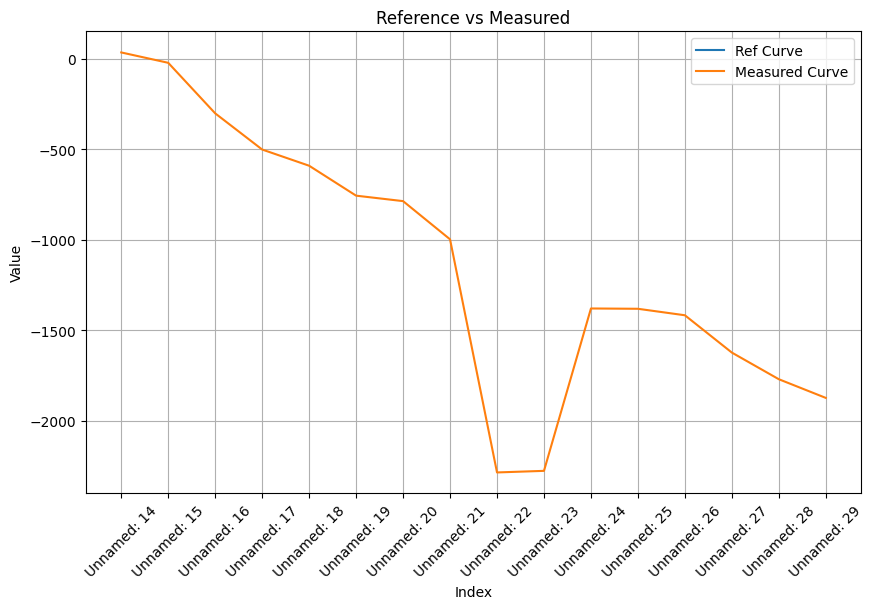

In [77]:
def plot_curves(Ref_curve, Field_curve):
    plt.figure(figsize=(10, 6))
    plt.plot(Ref_curve, label='Ref Curve')
    plt.plot(Field_curve, label='Measured Curve')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.tick_params(axis='x', rotation=45)
    plt.title('Reference vs Measured')
    plt.legend()
    plt.show()

plot_curves(, )

In [ ]:
# calc AIIC test results and plot
# pull test data from single_test_data
# single_AIIC_test_data

In [ ]:
def calc_AIIC_val(Normalized_recieve_IIC):
    AIIC_start = 93
    IIC_curve = [2,2,2,2,2,2,1,0,-1,-2,-3,-6,-9,-12,-15,-18]
    counter = 0
    while counter < 1000:  # limit the number of iterations
        print('starting loop')
        print('AIIC fit test value: ', AIIC_start)
        
        New_curve = [val + AIIC_start for val in IIC_curve]
        diff_negative =  np.max(np.array(New_curve) - np.array(Normalized_recieve_IIC))
        print('Max, single diff: ', diff_negative)
        pos_diffs = [np.round(val) if val > 0 else 0 for val in New_curve]
        new_sum = np.sum(pos_diffs)
        print('Sum Positive diffs: ', new_sum)

        if new_sum > 32 or diff_negative > 8:
            print('Curve too high! AIIC fit: ', AIIC_start-1)
            AIIC_finalrating = AIIC_start-1
            AIIC_curve = [val + AIIC_finalrating for val in IIC_curve]
            return AIIC_finalrating, AIIC_curve

        AIIC_start = AIIC_start - 1
        if AIIC_start <10: break
        counter += 1  # increment the counter